# Descrição

### O objetrivo é analisar uma base de dados com informações de condições de solo e temperatura, relacionadas com o tipo de produto agrícola dessa fazenda. Vamos criar modelos para prever o rendimento de safra e explorar a tendência de produtividade

### Base de dados: crop_yield.csv

- Cultura: o nome da safra para a qual o rendimento está sendo medido.

- Precipitação (mm dia 1): a quantidade de chuva em milímetros por dia.

- Umidade específica a 2 metros (g/kg): a quantidade de vapor de água no ar por quilograma de ar seco a uma altura de 2 metros acima do solo.

- Umidade relativa a 2 metros (%): a quantidade de vapor de água no ar como uma porcentagem da quantidade máxima de vapor de água que pode ser mantida a uma determinada temperatura e pressão.

- Temperatura a 2 metros (ºC): a temperatura em graus Celsius a uma altura de 2 metros acima do solo.

- Rendimento: a quantidade de rendimento em toneladas por hectare.

#FAZER

Fazer uma análise exploratória na base para se familiarizar com os dados;

Encontrar tendências para os rendimentos das plantações, por meio de clusterizações, e identificar se existem cenários discrepantes (outliers);



# Importação das Bibliotecas Necessárias

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

# Carregar o dataset

In [173]:
# Subir os dados e criar o DataFrame
df = pd.read_csv('/content/crop_yield.csv')

In [174]:
df.head()

,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


# Renomeando as Colunas

In [175]:
df.columns

Index(['Crop', 'Precipitation (mm day-1)',
       'Specific Humidity at 2 Meters (g/kg)',
       'Relative Humidity at 2 Meters (%)', 'Temperature at 2 Meters (C)',
       'Yield'],
      dtype='object')

In [176]:
df.rename(columns={
    'Crop': 'Cultura',
    'Precipitation (mm day-1)': 'Precipitação (mm dia 1)',
    'Specific Humidity at 2 Meters (g/kg)': 'Umidade Específica a 2 Metros (g/kg)',
    'Relative Humidity at 2 Meters (%)': 'Umidade Relativa a 2 Metros (%)',
    'Temperature at 2 Meters (C)': 'Temperatura a 2 Metros (C)',
    'Yield': 'Rendimento'
}, inplace=True)

df.head()

,Cultura,Precipitação (mm dia 1),Umidade Específica a 2 Metros (g/kg),Umidade Relativa a 2 Metros (%),Temperatura a 2 Metros (C),Rendimento
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


# Análise Inicial do dataset

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Cultura                               156 non-null    object 
 1   Precipitação (mm dia 1)               156 non-null    float64
 2   Umidade Específica a 2 Metros (g/kg)  156 non-null    float64
 3   Umidade Relativa a 2 Metros (%)       156 non-null    float64
 4   Temperatura a 2 Metros (C)            156 non-null    float64
 5   Rendimento                            156 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.4+ KB


### O Dataset tem 156 registros e 6 colunas.
### É consideravelmente pequeno o Dataset

In [178]:
df.describe()

,Precipitação (mm dia 1),Umidade Específica a 2 Metros (g/kg),Umidade Relativa a 2 Metros (%),Temperatura a 2 Metros (C),Rendimento
count,156.000000,156.000000,156.000000,156.00000,156.000000
mean,2486.498974,18.203077,84.737692,26.18359,56153.096154
std,289.457914,0.293923,0.996226,0.26105,70421.958897
min,1934.620000,17.540000,82.110000,25.56000,5249.000000
25%,2302.990000,18.030000,84.120000,26.02000,8327.750000
50%,2424.550000,18.270000,84.850000,26.13000,18871.000000
75%,2718.080000,18.400000,85.510000,26.30000,67518.750000
max,3085.790000,18.700000,86.100000,26.81000,203399.000000


# Limpeza e Tratamento inicial dos dados

Verificando dados nulos

In [179]:
df.isna().sum()

,0
Cultura,0
Precipitação (mm dia 1),0
Umidade Específica a 2 Metros (g/kg),0
Umidade Relativa a 2 Metros (%),0
Temperatura a 2 Metros (C),0
Rendimento,0


In [180]:
# Verificando se não há valores "na" ou semelhantes
print(df['Cultura'].unique())
print(df['Precipitação (mm dia 1)'].unique())
print(df['Umidade Específica a 2 Metros (g/kg)'].unique())
print(df['Umidade Relativa a 2 Metros (%)'].unique())
print(df['Temperatura a 2 Metros (C)'].unique())
print(df['Rendimento'].unique())

['Cocoa, beans' 'Oil palm fruit' 'Rice, paddy' 'Rubber, natural']
[2248.92 1938.42 2301.54 2592.35 2344.72 2339.3  2326.09 2718.08 2061.61
 1934.62 2217.12 2249.7  2530.96 2504.7  2686.2  2414.79 1999.53 2362.8
 2792.95 2751.24 2646.28 2302.99 2692.34 2424.55 2363.63 2892.78 2729.53
 3085.79 2922.18 2546.33 2938.29 2771.73 2607.96 2604.59 2308.51 2410.13
 2967.41 2333.46 2109.34]
[17.72 17.54 17.81 17.61 17.7  18.09 18.3  17.8  17.94 18.03 18.01 18.15
 18.19 18.38 18.18 18.2  18.7  18.24 18.31 18.4  18.22 18.37 18.28 18.35
 18.49 18.41 18.34 18.43 18.27 18.58 18.67 18.5  18.51]
[83.4  82.11 82.79 85.07 84.12 84.54 84.63 85.43 84.36 83.43 84.39 84.24
 85.33 85.45 85.77 85.76 84.03 86.04 85.98 86.02 84.48 85.54 85.16 84.92
 86.09 86.03 86.1  85.51 84.23 85.42 84.98 84.67 83.44 83.65 83.45 85.48
 84.85 83.52]
[26.01 26.11 26.24 25.56 25.76 26.12 25.88 26.21 26.1  26.02 26.13 25.93
 26.27 26.79 25.95 26.25 26.18 26.28 26.03 26.23 26.49 26.06 26.3  26.35
 26.43 26.47 26.81 26.46 26.72]
[ 11

## Verificando dados duplicados

In [181]:
duplicados = df.duplicated()
num_duplicates = duplicados.sum()
print(f"Número de registros duplicados: {num_duplicates}")

Número de registros duplicados: 0


### Confirmando que todas as features tem a mesma quantidade

In [182]:
df.count()

,0
Cultura,156
Precipitação (mm dia 1),156
Umidade Específica a 2 Metros (g/kg),156
Umidade Relativa a 2 Metros (%),156
Temperatura a 2 Metros (C),156
Rendimento,156


#Separando as variáveis numéricas para análise

In [183]:
df_numericos = df.drop(columns=['Cultura'])
df_numericos.head()

,Precipitação (mm dia 1),Umidade Específica a 2 Metros (g/kg),Umidade Relativa a 2 Metros (%),Temperatura a 2 Metros (C),Rendimento
0,2248.92,17.72,83.40,26.01,11560
1,1938.42,17.54,82.11,26.11,11253
2,2301.54,17.81,82.79,26.24,9456
3,2592.35,17.61,85.07,25.56,9321
4,2344.72,17.61,84.12,25.76,8800


# Análise Exploratória de Dados
## Distribuição das Variáveis Númericas

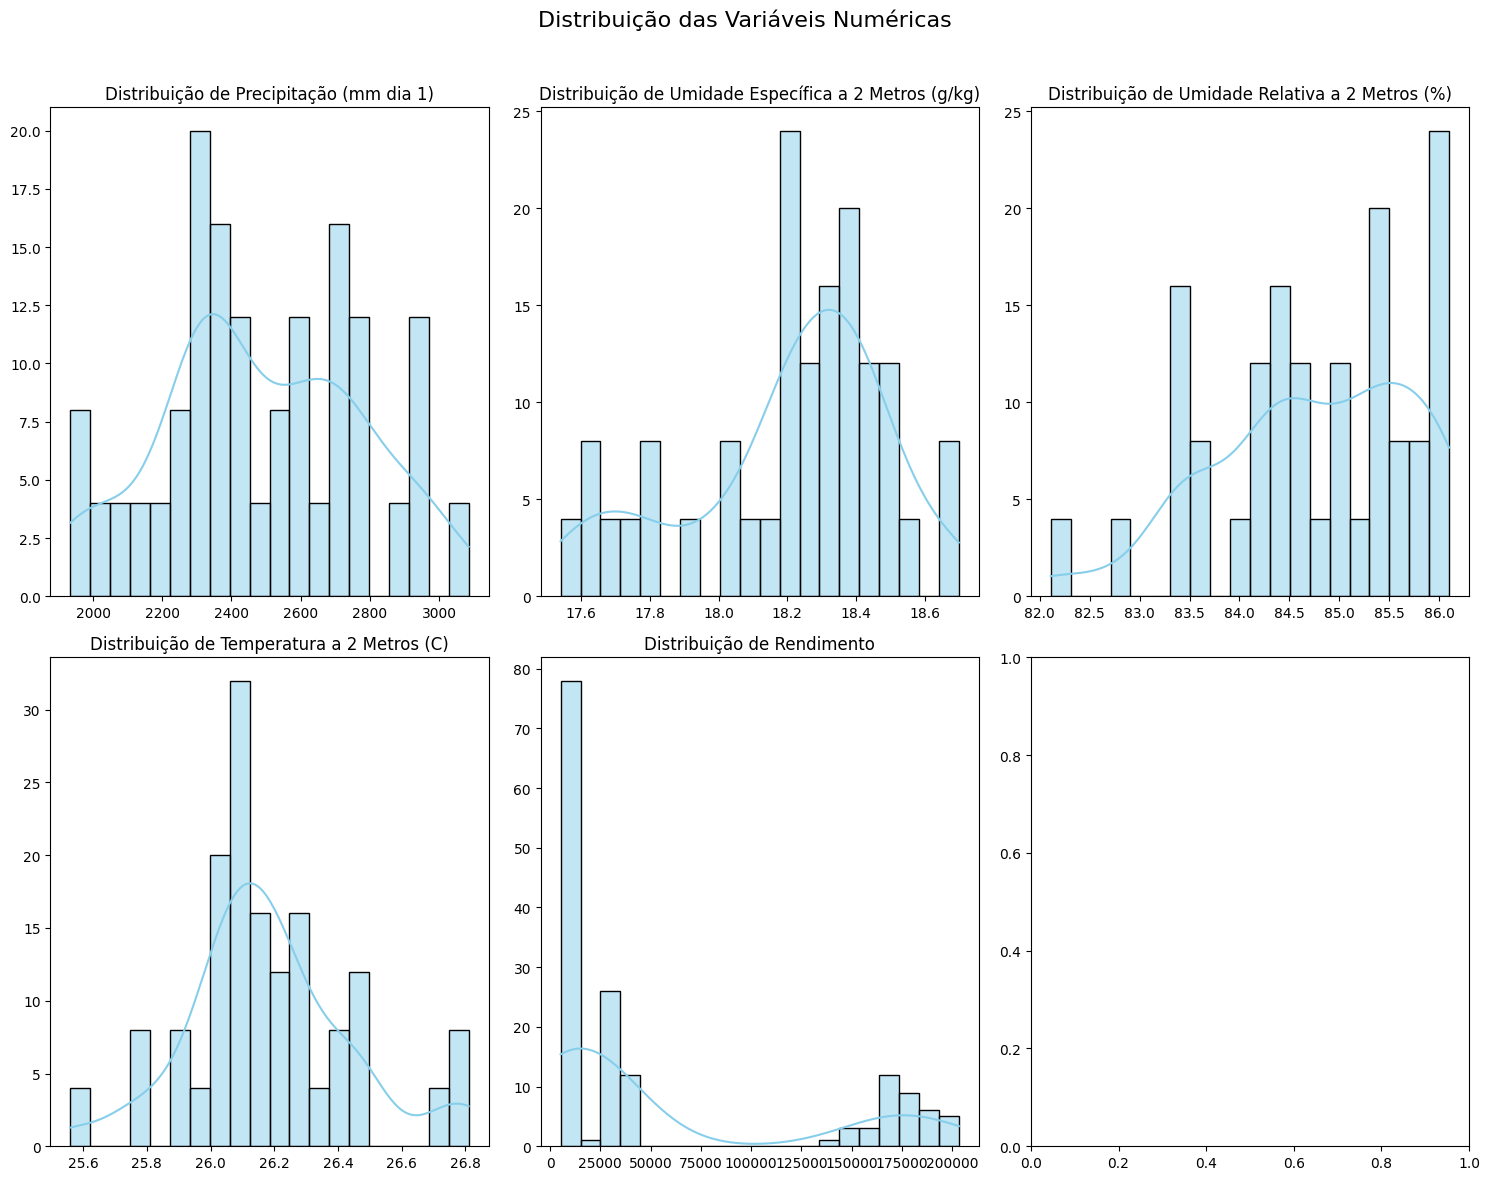

In [184]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12))
fig.suptitle('Distribuição das Variáveis Numéricas', fontsize=16)

df_numericos = df.select_dtypes(include=['number']).columns
for i, column in enumerate(df_numericos):
    ax = axs[i // 3, i % 3]
    sns.histplot(df[column], bins=20, kde=True, ax=ax, color='skyblue')
    ax.set_title(f'Distribuição de {column}')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

###Visualmente vemos que quase todas as features númericas seguem uma distribuição próxima da normal, com exceção de Rendimento

# Identificação de Outliers com Boxplot

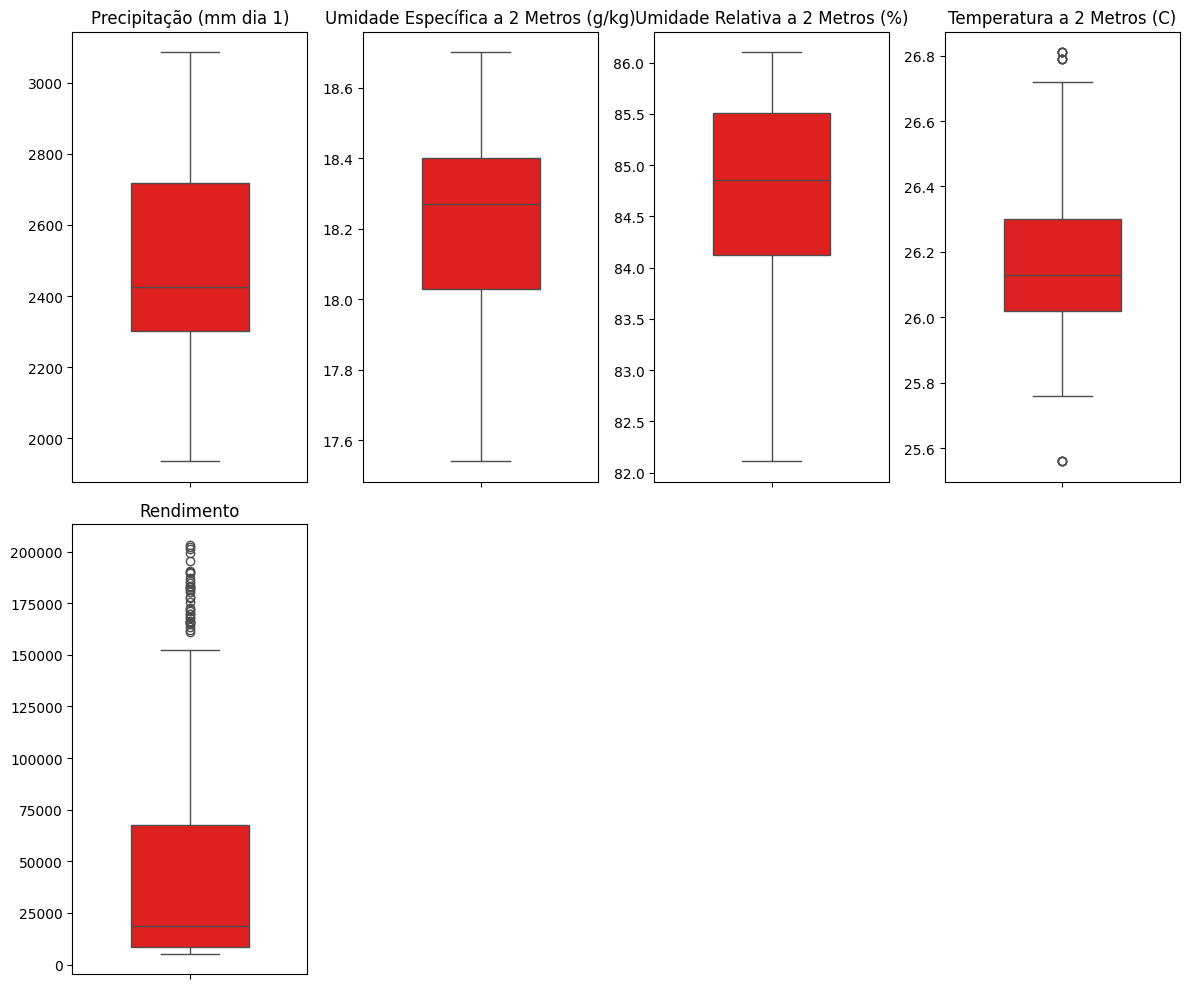

In [185]:
# Assuming df_numericos is already a DataFrame with numerical columns
# If not, create it:
df_numericos = df.select_dtypes(include=['number'])

# Calculando o número de colunas no df_numericos.
num_cols = len(df_numericos.columns)

# Calculando o número de linhas necessárias para exibir todos os boxplots
num_rows = (num_cols + 3) // 4

# Configurando os boxplots
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(12, 5 * num_rows))
axes = axes.flatten()

# Iterando e criandos os boxplots
for i, col in enumerate(df_numericos.columns):
    sns.boxplot(y=df_numericos[col], ax=axes[i], width=0.5, color='red')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Removendo os espaços vazios
for i in range(num_cols, len(axes)):
    axes[i].axis('off')

# Ajustando o layout
plt.tight_layout()
plt.show()

## É possível identificar que as features "Rendimento" e "Temperatura a 2 Metros(C)" possuem possíveis casos de Outliers

In [186]:
rendimento_alto = df[df['Rendimento'] > 200000]
num_rendimento_alto = len(rendimento_alto)
print(f"Registros com Rendimento maior que 200000: {num_rendimento_alto}")

Registros com Rendimento maior que 200000: 3


In [187]:
Temp2metros = df[df['Temperatura a 2 Metros (C)'] > 26.8]
num_Temp2metros = len(Temp2metros)
print(f"Registros com Temperatura a 2 Metros (C) maior que 26.8: {num_Temp2metros}")

Registros com Temperatura a 2 Metros (C) maior que 26.8: 4


In [188]:
df_semoutlier = df[(df['Rendimento'] <= 200000) & (df['Temperatura a 2 Metros (C)'] <= 26.8)]
df_semoutlier.head()

,Cultura,Precipitação (mm dia 1),Umidade Específica a 2 Metros (g/kg),Umidade Relativa a 2 Metros (%),Temperatura a 2 Metros (C),Rendimento
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


#Buscando Tendências com a Variável Rendimentos

## Aqui vamos plotar graficamente para tentar já identificar possíveis relações de clusters entre algumas variáveis.

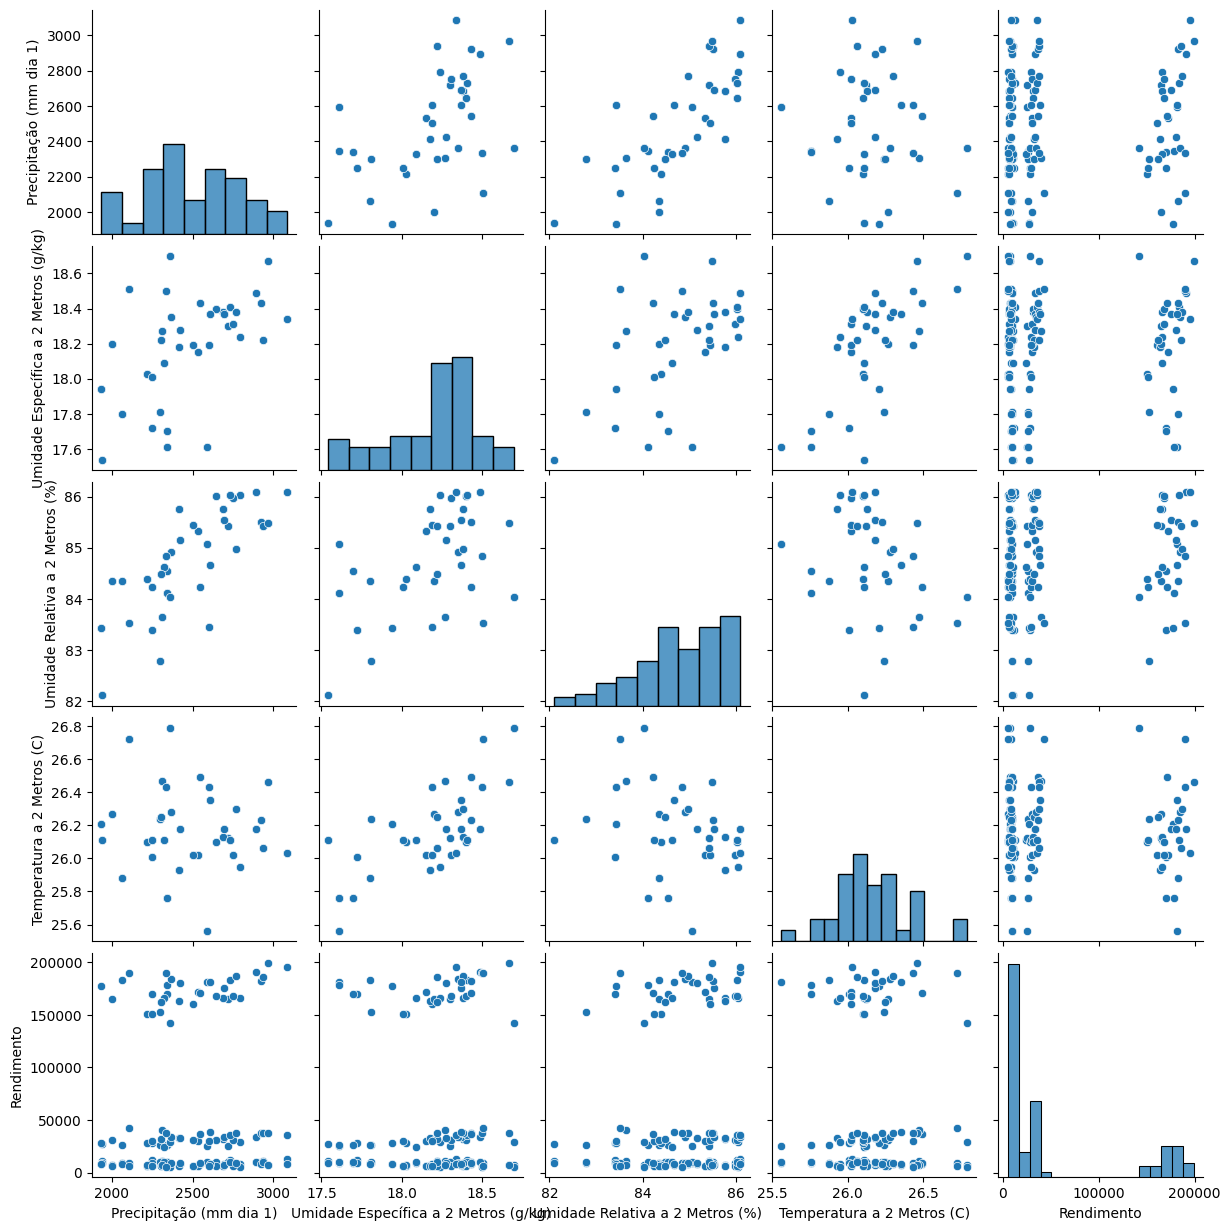

In [189]:
sns.pairplot(df_semoutlier)
plt.show()

# Clusterizando e identificando Tendências com K-Means

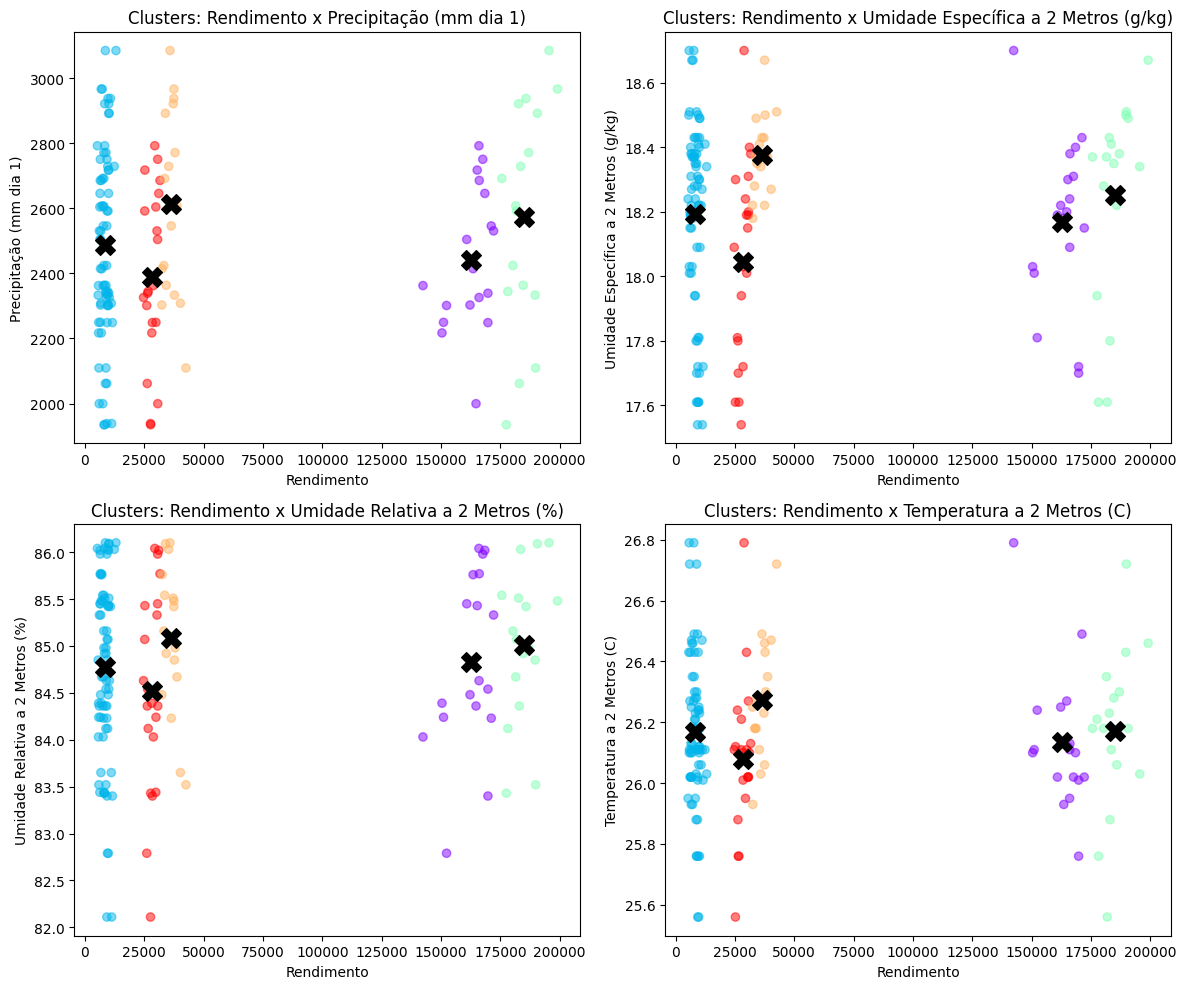

In [190]:
# Seleciona só as variáveis numéricas
df_numericos = df_semoutlier.select_dtypes(include=['number']).columns

# Remove a variável "Rendimento" da lista
variaveis = [col for col in df_numericos if col != "Rendimento"]

# Numero de clusters
n_clusters = 5

# Cria uma grade de subplots com base na quantidade de variáveis
n_cols = 2
n_rows = (len(variaveis) + 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 5*n_rows))

axs = axs.flatten()

for i, var in enumerate(variaveis):

    # Instancia e ajusta o k-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_semoutlier[["Rendimento", var]])

    # Labels dos clusters
    labels = kmeans.predict(df_semoutlier[["Rendimento", var]])

    # Centroides
    centroids = kmeans.cluster_centers_

    # Plot
    axs[i].scatter(df_semoutlier["Rendimento"], df_semoutlier[var],
                   c=labels, alpha=0.5, cmap="rainbow")
    axs[i].scatter(centroids[:, 0], centroids[:, 1],
                   c="black", marker="X", s=200)
    axs[i].set_title(f"Clusters: Rendimento x {var}")
    axs[i].set_xlabel("Rendimento")
    axs[i].set_ylabel(var)

# Remove gráficos extras se a grade for maior que o necessário
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


### Com K-Means já conseguimos identificar possíveis clusters e relações. Contudo devido as variáveis serem bem parecidas (umidade, temperatura e precipitação) os clusters são bem similares.

Isso pode ser preocupante e já mostrar uma alta correlação entre as variáveis

# Análise de Correlações

In [191]:
# Analisando a correlação entre as variáveis numéricas

corr = df_semoutlier.select_dtypes(include=['number']).corr(method='pearson')
corr

,Precipitação (mm dia 1),Umidade Específica a 2 Metros (g/kg),Umidade Relativa a 2 Metros (%),Temperatura a 2 Metros (C),Rendimento
Precipitação (mm dia 1),1.000000,0.497324,0.760047,-0.075229,0.051346
Umidade Específica a 2 Metros (g/kg),0.497324,1.000000,0.489552,0.699087,0.042704
Umidade Relativa a 2 Metros (%),0.760047,0.489552,1.000000,-0.280735,0.079503
Temperatura a 2 Metros (C),-0.075229,0.699087,-0.280735,1.000000,-0.017404
Rendimento,0.051346,0.042704,0.079503,-0.017404,1.000000


Text(0.5, 1.0, 'Análise de Correlação')

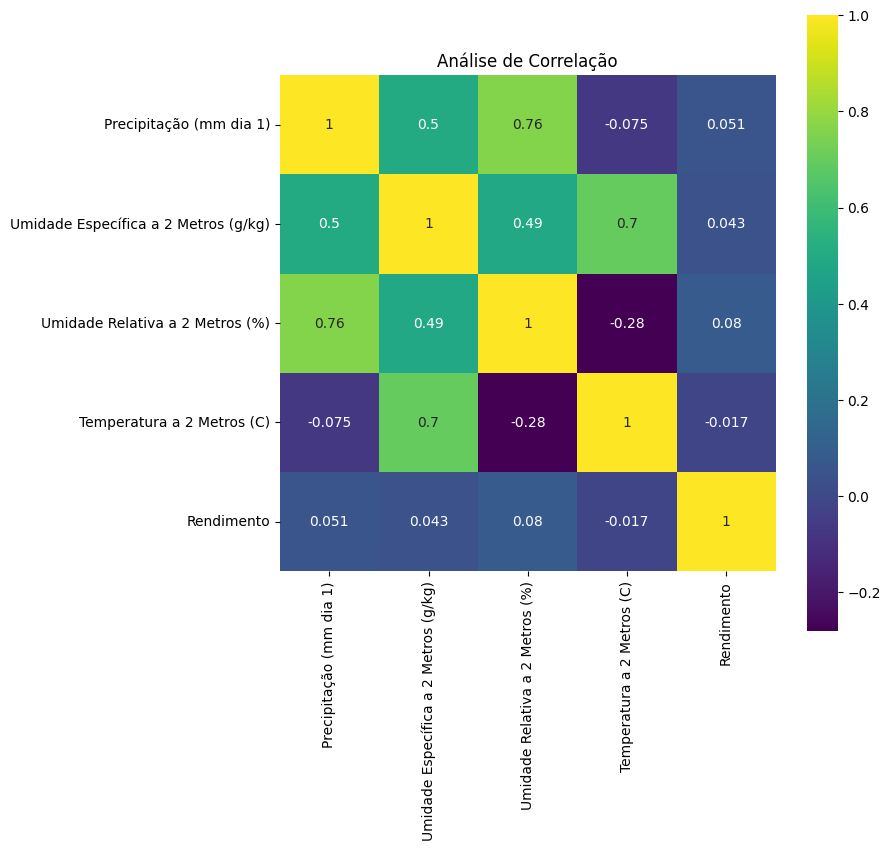

In [192]:
## Grafico de correlação de Pearson das features númericas.

correlation = df_semoutlier.select_dtypes(include=['number']).corr(method='pearson')
plt.figure(figsize=(8,8))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')

plt.title('Análise de Correlação')

#Transformando a Variável Cultura com One Hot Encode

In [193]:
# Use get_dummies for one-hot encoding
df_semoutlier = pd.get_dummies(df_semoutlier, columns=['Cultura'], prefix='Cultura', dtype=int)

# Display the first few rows with the new encoded columns
display(df_semoutlier.head())

,Precipitação (mm dia 1),Umidade Específica a 2 Metros (g/kg),Umidade Relativa a 2 Metros (%),Temperatura a 2 Metros (C),Rendimento,"Cultura_Cocoa, beans",Cultura_Oil palm fruit,"Cultura_Rice, paddy","Cultura_Rubber, natural"
0,2248.92,17.72,83.40,26.01,11560,1,0,0,0
1,1938.42,17.54,82.11,26.11,11253,1,0,0,0
2,2301.54,17.81,82.79,26.24,9456,1,0,0,0
3,2592.35,17.61,85.07,25.56,9321,1,0,0,0
4,2344.72,17.61,84.12,25.76,8800,1,0,0,0


Fazer cinco modelos preditivos (cada um com um algoritmo diferente, conforme visto no capítulo “Modelagem de Dados com Regressão Supervisionada”) que, dadas as condições, prevejam qual será o rendimento da safra. Esta parte da tarefa inclui seguir as boas práticas dos projetos de Machine Learning, assim como avaliar o modelo com métricas pertinentes ao problema.

# Separação das Variáveis Independentes e Dependente

In [194]:
X = df_semoutlier.drop('Rendimento', axis=1)
y = df_semoutlier['Rendimento']

In [195]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [196]:
scaler = StandardScaler()

# Escalando os dados
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertendo os dados escalados em Dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

display(X_train_scaled.head())
display(X_test_scaled.head())

,Precipitação (mm dia 1),Umidade Específica a 2 Metros (g/kg),Umidade Relativa a 2 Metros (%),Temperatura a 2 Metros (C),"Cultura_Cocoa, beans",Cultura_Oil palm fruit,"Cultura_Rice, paddy","Cultura_Rubber, natural"
0,0.727862,0.623697,0.780176,0.086989,1.761661,-0.567646,-0.593526,-0.580585
1,-0.242415,-0.024661,1.006994,-0.965015,1.761661,-0.567646,-0.593526,-0.580585
2,1.531351,0.828441,0.749246,0.297390,-0.567646,1.761661,-0.593526,-0.580585
3,-0.819547,-0.604771,-0.560115,-0.207572,1.761661,-0.567646,-0.593526,-0.580585
4,-0.506318,-1.662618,-0.250817,-1.680379,-0.567646,1.761661,-0.593526,-0.580585


,Precipitação (mm dia 1),Umidade Específica a 2 Metros (g/kg),Umidade Relativa a 2 Metros (%),Temperatura a 2 Metros (C),"Cultura_Cocoa, beans",Cultura_Oil palm fruit,"Cultura_Rice, paddy","Cultura_Rubber, natural"
0,-0.822274,-1.594369,-1.426149,-0.628374,-0.567646,-0.567646,1.684847,-0.580585
1,1.079581,0.180083,1.295672,-0.880855,1.761661,-0.567646,-0.593526,-0.580585
2,-0.552498,-0.331778,-0.158028,-0.207572,-0.567646,-0.567646,-0.593526,1.722401
3,-0.506318,-1.662618,-0.250817,-1.680379,-0.567646,-0.567646,1.684847,-0.580585
4,0.378310,-1.969734,0.295609,-2.521982,-0.567646,-0.567646,1.684847,-0.580585


## Função de avaliação de modelos

In [197]:
def avaliar_modelo(nome, modelo, X_train, X_test, y_train, y_test):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {"Modelo": nome, "RMSE": rmse, "MAE": mae, "R²": r2}

# Regressão Linear

In [198]:
# Treinar o modelo
RegressionSimples = LinearRegression()
RegressionSimples.fit(X_train, y_train)
y_pred = RegressionSimples.predict(X_test)


In [199]:
avaliar_modelo("Regressão Linear Simples", RegressionSimples, X_train, X_test, y_train, y_test)

{'Modelo': 'Regressão Linear Simples',
 'RMSE': np.float64(6437.91178126923),
 'MAE': 4553.340986311616,
 'R²': 0.9907381999715569}

# DecisionTreeRegressor

In [200]:
# Treinar o modelo
DecisionTree = DecisionTreeRegressor()
DecisionTree.fit(X_train_scaled, y_train)
y_pred = DecisionTree.predict(X_test_scaled)

In [201]:
avaliar_modelo("Decision Tree", DecisionTree, X_train_scaled, X_test_scaled, y_train, y_test)

{'Modelo': 'Decision Tree',
 'RMSE': np.float64(8196.877771444442),
 'MAE': 4267.466666666666,
 'R²': 0.9849857972710432}

#Random Forest

In [202]:
# Treinar o modelo
RandomForest = RandomForestRegressor(n_estimators=100, random_state=42)
RandomForest.fit(X_train_scaled, y_train)
y_pred = RandomForest.predict(X_test_scaled)

In [203]:
avaliar_modelo("Random Forest", RandomForest, X_train_scaled, X_test_scaled, y_train, y_test)

{'Modelo': 'Random Forest',
 'RMSE': np.float64(5334.6205845433215),
 'MAE': 3278.0893333333343,
 'R²': 0.993640654358787}

#XGBoost

In [204]:
# Treinar o modelo
XGBOOST = XGBRegressor(n_estimators=100, random_state=42, learning_rate=0.1)
XGBOOST.fit(X_train_scaled, y_train)
y_pred = XGBOOST.predict(X_test_scaled)

In [205]:
avaliar_modelo("XGBoost", XGBOOST, X_train_scaled, X_test_scaled, y_train, y_test)


{'Modelo': 'XGBoost',
 'RMSE': np.float64(5163.809252867499),
 'MAE': 3211.03515625,
 'R²': 0.994041383266449}

#SVR (Support Vector Regressor)

In [206]:
# Treinar o modelo
SVRModel = SVR(kernel="rbf")
SVRModel.fit(X_train_scaled, y_train)
y_pred = SVRModel.predict(X_test_scaled)

In [207]:
avaliar_modelo("SVR", SVRModel, X_train_scaled, X_test_scaled, y_train, y_test)

{'Modelo': 'SVR',
 'RMSE': np.float64(70913.77676558137),
 'MAE': 42105.697438859825,
 'R²': -0.12374193842189252}

#Visualização das Métricas

In [208]:
resultados = []

# 1. Regressão Linear
resultados.append(avaliar_modelo("Regressão Linear", LinearRegression(), X_train, X_test, y_train, y_test))

# 2. Árvore de Regressão
resultados.append(avaliar_modelo("Árvore de Regressão", DecisionTreeRegressor(random_state=42), X_train, X_test, y_train, y_test))

# 3. Random Forest
resultados.append(avaliar_modelo("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42), X_train, X_test, y_train, y_test))

# 4. XGBoost
resultados.append(avaliar_modelo("XGBoost", XGBRegressor(n_estimators=100, random_state=42, learning_rate=0.1), X_train, X_test, y_train, y_test))

# 5. Support Vector Regressor (SVR)
resultados.append(avaliar_modelo("SVR", SVR(kernel="rbf"), X_train, X_test, y_train, y_test))

# ------------------------------
# Resultados finais
# ------------------------------
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

                Modelo          RMSE           MAE        R²
0     Regressão Linear   6437.911781   4553.340986  0.990738
1  Árvore de Regressão   8574.888526   4804.500000  0.983569
2        Random Forest   5340.892732   3282.650333  0.993626
3              XGBoost   5163.809253   3211.035156  0.994041
4                  SVR  70915.644934  42117.426314 -0.123801


#Análise e Conclusão

### Melhores Modelos

## XGBoost
Melhor desempenho geral, com o menor RMSE (5163), menor MAE (3211) e maior R² (0.9940).

## Random Forest
Métricas exelentes também, bem próximo do XGBOOST.

Os modelos baseados em ensembles de árvores são excelentes para prever rendimento agrícola, porque capturam relações não lineares e interações entre variáveis.

## Regressão Linear

Teve um R² alto (0.991) → indica que os dados têm forte correlação linear com o rendimento.

Porém, o erro médio (RMSE/MAE) é maior do que Random Forest e XGBoost.

Serve bem como baseline, mas não é o ideal.

## Árvore de Regressão Simples

RMSE de 8575, pior que a regressão linear.

Apesar de capturar não linearidades, overfitting e baixa generalização reduzem sua performance.

Mas útil para interpretação visual.

## SVR (Support Vector Regressor)

Resultado muito ruim (RMSE 70.916 e R² negativo).

O R² < 0 significa que o modelo está pior do que prever sempre a média.

Isso mostra que o SVR não se ajustou ao dataset, provavelmente porque os Dados não foram escalonados corretamente para ele (SVR é sensível a escala).
